# Задача №5: Прогнозирование выживания пациентов с циррозом печени

## Описание задачи

Цирроз печени является серьезным состоянием, вызванным длительным повреждением печени и образованием обширных рубцовых тканей. Это часто происходит вследствие таких состояний, как гепатит или хроническое употребление алкоголя. Данный датасет основан на исследовании, проведенном Майской клиникой (Mayo Clinic) в период с 1974 по 1984 год.

Ваша задача - создать модель машинного обучения для прогнозирования выживания пациентов с циррозом печени на основе имеющихся данных.

## Описание датасета

Исследование включает информацию о пациентах, включая их пол, возраст и другие атрибуты - всего 17 признаков. Дополнительные атрибуты включают данные об использовании лекарства D-penicillamine и исходе лечения. Всего записей - 418.

Таргет - **Status**

### Описание признаков

1) ID: unique identifier

2) N_Days: number of days between registration and the earlier of death, transplantation, or study analysis time in July 1986

3) Status: status of the patient C (censored), CL (censored due to liver tx), or D (death)

4) Drug: type of drug D-penicillamine or placebo

5) Age: age in [days]

6) Sex: M (male) or F (female)

7) Ascites: presence of ascites N (No) or Y (Yes)

8) Hepatomegaly: presence of hepatomegaly N (No) or Y (Yes)

9) Spiders: presence of spiders N (No) or Y (Yes)

10) Edema: presence of edema N (no edema and no diuretic therapy for edema), S (edema present without diuretics, or edema resolved by diuretics), or Y (edema despite diuretic therapy)

11) Bilirubin: serum bilirubin in [mg/dl]

12) Cholesterol: serum cholesterol in [mg/dl]

13) Albumin: albumin in [gm/dl]

14) Copper: urine copper in [ug/day]

15) Alk_Phos: alkaline phosphatase in [U/liter]

16) SGOT: SGOT in [U/ml]

17) Triglycerides: triglicerides in [mg/dl]

18) Platelets: platelets per cubic [ml/1000]

19) Prothrombin: prothrombin time in seconds [s]

20) Stage: histologic stage of disease (1, 2, 3, or 4)



## Импорт библиотек

In [ ]:
!pip install catboost

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.impute import KNNImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
import pickle
from catboost import CatBoostClassifier

## Загрузка и подготовка данных

In [ ]:
!unzip /content/dataset5.zip

In [ ]:
df = pd.read_csv('/content/cirrhosis.csv')
df.head()

ID  N_Days Status             Drug    Age Sex Ascites Hepatomegaly Spiders  \
0   1     400      D  D-penicillamine  21464   F       Y            Y       Y   
1   2    4500      C  D-penicillamine  20617   F       N            Y       Y   
2   3    1012      D  D-penicillamine  25594   M       N            N       N   
3   4    1925      D  D-penicillamine  19994   F       N            Y       Y   
4   5    1504     CL          Placebo  13918   F       N            Y       Y   

  Edema  Bilirubin  Cholesterol  Albumin  Copper  Alk_Phos    SGOT  \
0     Y       14.5        261.0     2.60   156.0    1718.0  137.95   
1     N        1.1        302.0     4.14    54.0    7394.8  113.52   
2     S        1.4        176.0     3.48   210.0     516.0   96.10   
3     S        1.8        244.0     2.54    64.0    6121.8   60.63   
4     N        3.4        279.0     3.53   143.0     671.0  113.15   

   Tryglicerides  Platelets  Prothrombin  Stage  
0          172.0      190.0         12.2    4.0  
1           88.0      221.0         10.6    3.0  
2           55.0      151.0         12.0    4.0  
3           92.0      183.0         10.3    4.0  
4           72.0      136.0         10.9    3.0

In [ ]:
df.shape

(418, 20)

Мы имеем 418 наблюдений, 19 признаков и 1 таргет.

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 20 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   ID             418 non-null    int64  
 1   N_Days         418 non-null    int64  
 2   Status         418 non-null    object 
 3   Drug           312 non-null    object 
 4   Age            418 non-null    int64  
 5   Sex            418 non-null    object 
 6   Ascites        312 non-null    object 
 7   Hepatomegaly   312 non-null    object 
 8   Spiders        312 non-null    object 
 9   Edema          418 non-null    object 
 10  Bilirubin      418 non-null    float64
 11  Cholesterol    284 non-null    float64
 12  Albumin        418 non-null    float64
 13  Copper         310 non-null    float64
 14  Alk_Phos       312 non-null    float64
 15  SGOT           312 non-null    float64
 16  Tryglicerides  282 non-null    float64
 17  Platelets      407 non-null    float64
 18  Prothrombi

В большинстве своем признаки числовые, но среди них есть 7 категориальных. Кроме того, есть пропуски.

In [ ]:
df.isna().sum()

ID                 0
N_Days             0
Status             0
Drug             106
Age                0
Sex                0
Ascites          106
Hepatomegaly     106
Spiders          106
Edema              0
Bilirubin          0
Cholesterol      134
Albumin            0
Copper           108
Alk_Phos         106
SGOT             106
Tryglicerides    136
Platelets         11
Prothrombin        2
Stage              6
dtype: int64

Разберемся с ними позднее.

In [ ]:
cat_cols = ['Drug', 'Sex', 'Ascites', 'Hepatomegaly', 'Spiders', 'Edema']

for col in cat_cols:
    print(f"{col}: {df[col].unique()}")

Drug: ['D-penicillamine' 'Placebo' nan]
Sex: ['F' 'M']
Ascites: ['Y' 'N' nan]
Hepatomegaly: ['Y' 'N' nan]
Spiders: ['Y' 'N' nan]
Edema: ['Y' 'N' 'S']


In [ ]:
df['Status'].unique()

array(['D', 'C', 'CL'], dtype=object)

In [ ]:
df.describe()

ID       N_Days           Age   Bilirubin  Cholesterol  \
count  418.000000   418.000000    418.000000  418.000000   284.000000   
mean   209.500000  1917.782297  18533.351675    3.220813   369.510563   
std    120.810458  1104.672992   3815.845055    4.407506   231.944545   
min      1.000000    41.000000   9598.000000    0.300000   120.000000   
25%    105.250000  1092.750000  15644.500000    0.800000   249.500000   
50%    209.500000  1730.000000  18628.000000    1.400000   309.500000   
75%    313.750000  2613.500000  21272.500000    3.400000   400.000000   
max    418.000000  4795.000000  28650.000000   28.000000  1775.000000   

          Albumin      Copper      Alk_Phos        SGOT  Tryglicerides  \
count  418.000000  310.000000    312.000000  312.000000     282.000000   
mean     3.497440   97.648387   1982.655769  122.556346     124.702128   
std      0.424972   85.613920   2140.388824   56.699525      65.148639   
min      1.960000    4.000000    289.000000   26.350000      33.000000   
25%      3.242500   41.250000    871.500000   80.600000      84.250000   
50%      3.530000   73.000000   1259.000000  114.700000     108.000000   
75%      3.770000  123.000000   1980.000000  151.900000     151.000000   
max      4.640000  588.000000  13862.400000  457.250000     598.000000   

        Platelets  Prothrombin       Stage  
count  407.000000   416.000000  412.000000  
mean   257.024570    10.731731    3.024272  
std     98.325585     1.022000    0.882042  
min     62.000000     9.000000    1.000000  
25%    188.500000    10.000000    2.000000  
50%    251.000000    10.600000    3.000000  
75%    318.000000    11.100000    4.000000  
max    721.000000    18.000000    4.000000

Если будем использовать линейные модели, то потребуется масштабирование.

Возраст измеряется в днях, переведем его в года

In [ ]:
df['Age']=df['Age']/365

ID никак не повлияет на обучение, поэтому можно удалить этот признак.

In [ ]:
df = df.drop('ID', axis=1)

Теперь разберемся с пропусками. Так как данных относительно мало, удалять строки с пропусками все таки не стоит. Категориальные заполним модой, а числовые через KNNImputer.

In [ ]:
for col in ['Drug', 'Ascites', 'Hepatomegaly', 'Spiders', 'Edema']:
    df[col] = df[col].fillna(value=df[col].mode()[0])

In [ ]:
num_cols = ['Age', 'Bilirubin', 'Cholesterol', 'Albumin', 'Copper', 'Alk_Phos',
            'SGOT', 'Tryglicerides', 'Platelets', 'Prothrombin', 'Stage']
imputer = KNNImputer(n_neighbors=3)
df[num_cols] = imputer.fit_transform(df[num_cols])

In [ ]:
df['Stage'] = df['Stage'].astype('int64')

In [ ]:
df['Stage'].unique()

array([4, 3, 2, 1])

In [ ]:
df.isna().sum()

N_Days           0
Status           0
Drug             0
Age              0
Sex              0
Ascites          0
Hepatomegaly     0
Spiders          0
Edema            0
Bilirubin        0
Cholesterol      0
Albumin          0
Copper           0
Alk_Phos         0
SGOT             0
Tryglicerides    0
Platelets        0
Prothrombin      0
Stage            0
dtype: int64

Пропуски обработаны.

## EDA

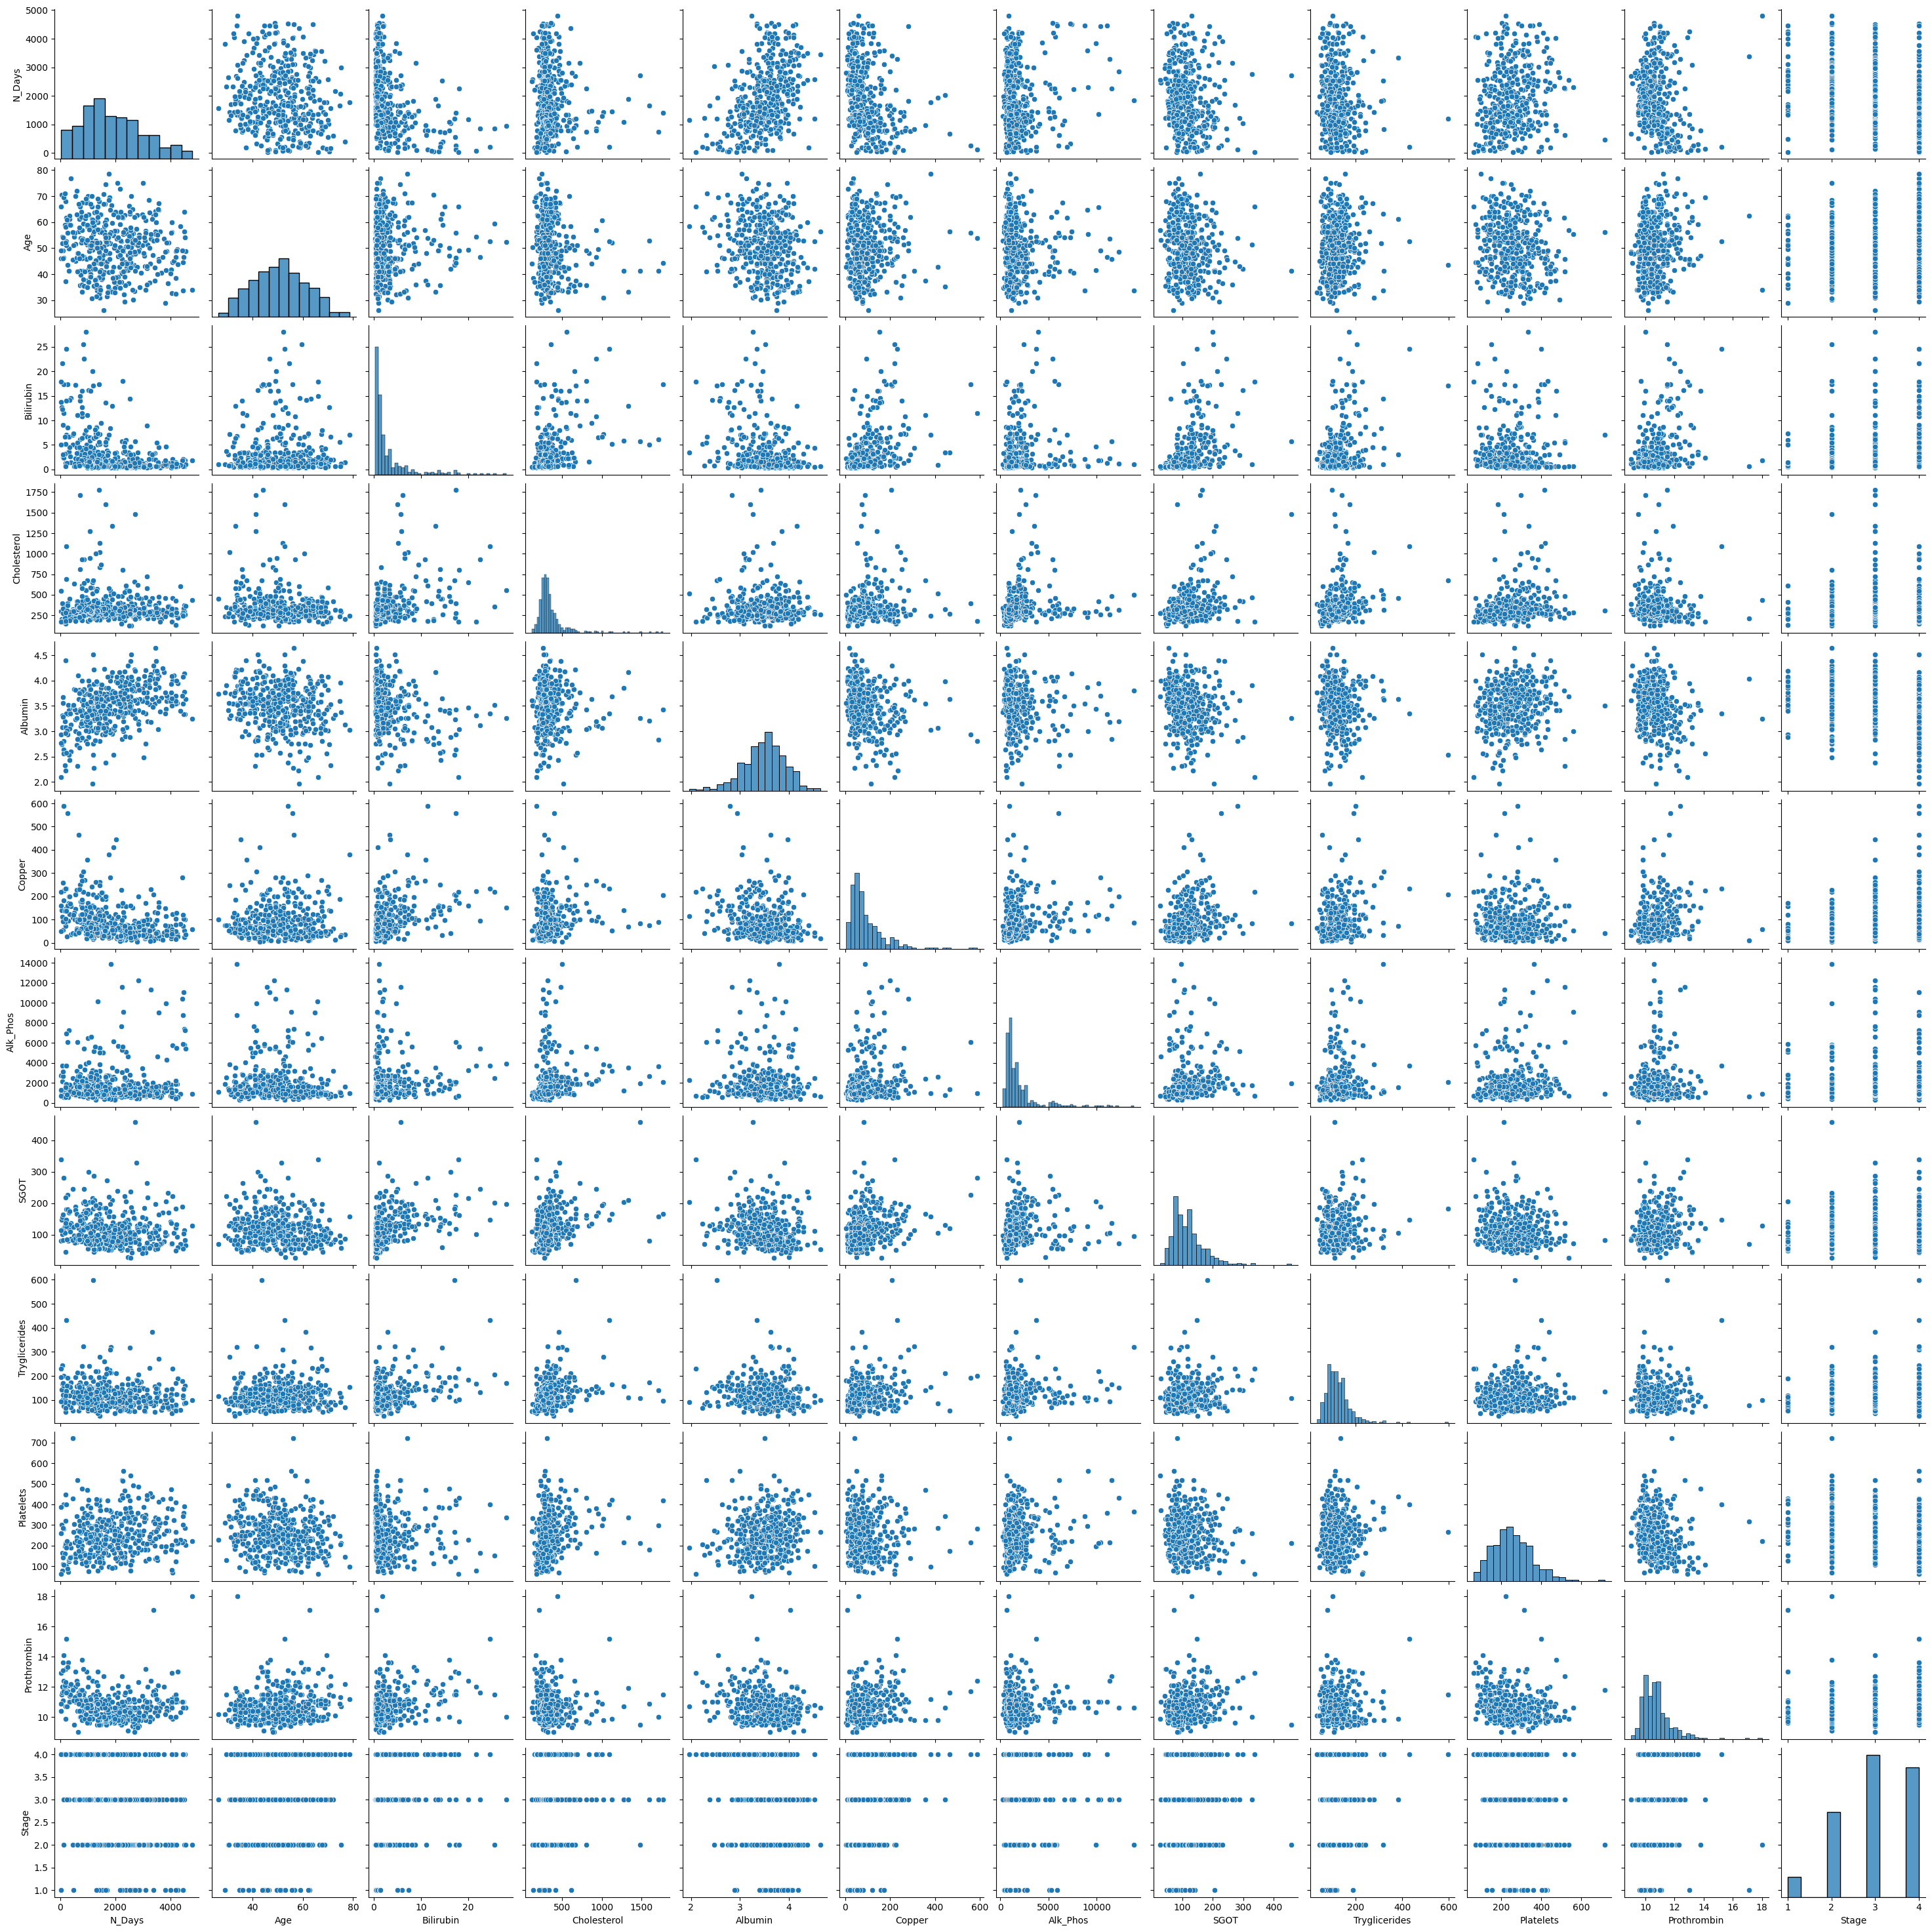

In [ ]:
sns.pairplot(df)

Каких-то явных линейных зависимостей среди признаков не наблюдается. Правда значения для некоторый пар склонны скапливаться в одной точке.

Теперь посмотрим на распределение классов таргета поближе.

<Axes: xlabel='Stage', ylabel='Count'>

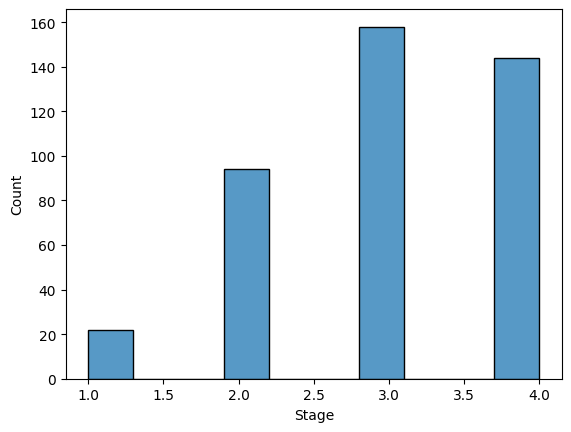

In [ ]:
sns.histplot(df['Stage'])

Построим матрицу корреляции признаков.

<ipython-input-20-6aa040d28d55>:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(df.corr(), annot=True)


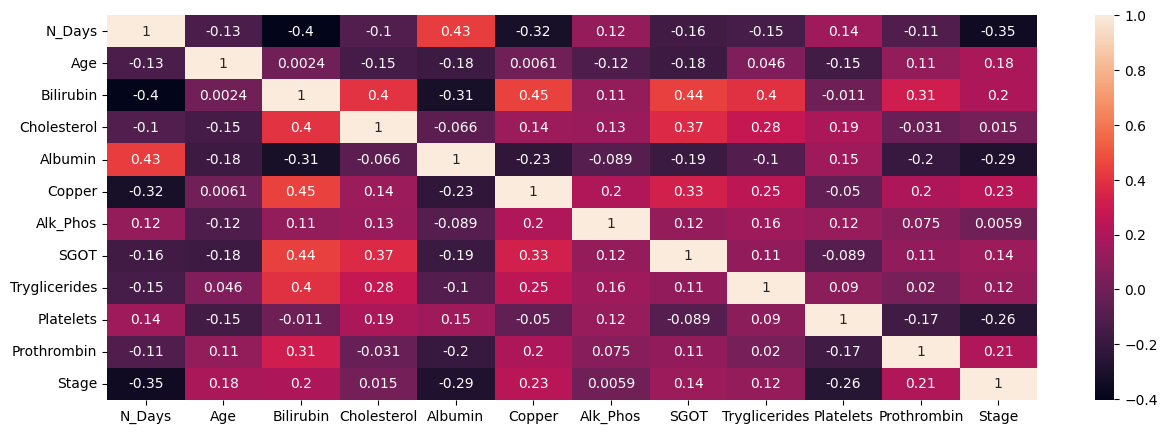

In [ ]:
fig, ax = plt.subplots(figsize=(15, 5))
sns.heatmap(df.corr(), annot=True)
plt.show()

Проблема мультиколлинеарности отсутствует.

## Предобработка данных

Так как максимальное кол-во уникальных значений в категориальных классах это 3, а одна из моделей будет линейная, то воспользуетмся OneHotEncoder.

In [ ]:
features = df.drop('Status', axis=1)
target = pd.factorize(df['Status'])[0]

In [ ]:
cat_cols

['Drug', 'Sex', 'Ascites', 'Hepatomegaly', 'Spiders', 'Edema']

In [ ]:
encoder = OneHotEncoder(handle_unknown='ignore', drop='first')

features_ohe = pd.DataFrame(encoder.fit_transform(features[cat_cols]).toarray(),
                            columns=encoder.get_feature_names_out())

Выполним масштабирование данных.

In [ ]:
num_cols = ['Age', 'Bilirubin', 'Cholesterol', 'Albumin', 'Copper', 'Alk_Phos',
            'SGOT', 'Tryglicerides', 'Platelets', 'Prothrombin', 'N_Days', 'Stage']

In [ ]:
scaler = StandardScaler()

features_numeric = pd.DataFrame(scaler.fit_transform(features[num_cols]),
                                columns=num_cols)

In [ ]:
features = features_ohe.join(features_numeric)
features.shape

(418, 19)

In [ ]:
features.head()

Drug_Placebo  Sex_M  Ascites_Y  Hepatomegaly_Y  Spiders_Y  Edema_S  \
0           0.0    0.0        1.0             1.0        1.0      0.0   
1           0.0    0.0        0.0             1.0        1.0      0.0   
2           0.0    1.0        0.0             0.0        0.0      1.0   
3           0.0    0.0        0.0             1.0        1.0      1.0   
4           1.0    0.0        0.0             1.0        1.0      0.0   

   Edema_Y       Age  Bilirubin  Cholesterol   Albumin    Copper  Alk_Phos  \
0      1.0  0.768941   2.562152    -0.478601 -2.114296  0.812275 -0.126624   
1      0.0  0.546706  -0.481759    -0.275570  1.513818 -0.501158  2.761300   
2      0.0  1.852567  -0.413611    -0.899519 -0.041088  1.507623 -0.738110   
3      0.0  0.383244  -0.322748    -0.562785 -2.255651 -0.372390  2.113694   
4      0.0 -1.210972   0.040704    -0.389465  0.076708  0.644877 -0.659258   

       SGOT  Tryglicerides  Platelets  Prothrombin    N_Days     Stage  
0  0.393034       0.867650  -0.683826     1.442170 -1.375612  1.116240  
1 -0.078978      -0.639470  -0.365802    -0.128715  2.340341 -0.016256  
2 -0.415550      -1.231553  -1.083922     1.245810 -0.820938  1.116240  
3 -1.100865      -0.567702  -0.755639    -0.423256  0.006542  1.116240  
4 -0.086127      -0.926541  -1.237805     0.165826 -0.375023 -0.016256

Соберем из этих шагов пайплайн и сохраним его.

In [ ]:
cat_transformer = Pipeline(steps=[('onehot', encoder)])
num_transformer = Pipeline(steps=[('imputer', imputer), ('scaler', scaler)])

preprocessor = ColumnTransformer(
    transformers=[
        ('cat', cat_transformer, cat_cols),
        ('num', num_transformer, num_cols)
    ])

pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor)
])

In [ ]:
with open('preprocessing_pipeline.pkl', 'wb') as file:
    pickle.dump(pipeline, file)

## SVC

In [ ]:
param_grid = {'C': [0.1, 1, 10],
              'kernel': ['linear', 'rbf']}

svc_cv = GridSearchCV(SVC(),
                            param_grid,
                            scoring='accuracy',
                            cv=5,
                            verbose=2)

svc_cv.fit(features, target)

In [ ]:
print(f'Accuracy: {svc_cv.best_score_}')

Accuracy: 0.751061388410786


In [ ]:
with open('svc.pkl', 'wb') as file:
    pickle.dump(svc_cv.best_estimator_, file)

## Случайный лес

In [ ]:
param_grid = {'n_estimators': [10, 50, 100, 200],
              'max_depth': [None, 10, 20, 30],
              'min_samples_leaf': [1, 2, 4]}

random_forest = GridSearchCV(RandomForestClassifier(random_state=52, n_jobs=-1),
                             param_grid,
                             scoring='accuracy',
                             cv=5,
                             verbose=0)

random_forest.fit(features, target)

print(f'Accuracy: {random_forest.best_score_}')

Accuracy: 0.7606712564543889


In [ ]:
with open('random_forest.pkl', 'wb') as file:
    pickle.dump(random_forest.best_estimator_, file)

## CatBoost

In [ ]:
param_grid = {'learning_rate': [0.001, 0.01, 0.1],
              'n_estimators': [100, 200, 300]}

catboost = GridSearchCV(CatBoostClassifier(),
                        param_grid,
                        scoring='accuracy',
                        cv=5,
                        verbose=0)

catboost.fit(features, target)

In [ ]:
print(f'Accuracy: {catboost.best_score_}')

Accuracy: 0.7415662650602409


In [ ]:
with open('catboost.pkl', 'wb') as file:
    pickle.dump(catboost.best_estimator_, file)